# Merger Rate in a Primordial Black Hole Cluster

## Code Writed by Tadeo D.
### Dedicated to the poetry of my life: Dra. Elizabeth América Flores Frías.

**References:** [arXiv:2105.14523](https://arxiv.org/pdf/2105.14523.pdf). [arXiv:1603.05234](https://arxiv.org/pdf/1603.05234.pdf)

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from itertools import combinations_with_replacement
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
from astropy import constants as cte
from astropy.units import Quantity


In [2]:
c = 299792458 #m/s
c_ast = 299792.458 #km/s
G = 6.6743e-11 #m^3 / (kg s^2)
G_ast = 4.517103049894964e-30 #pc^3 / (s^2 solMass)

In [3]:
# Parámetros del cúmulo
M_DM_cluster = 1e5#u.Msun 
M_PBH = 10#u.M_sun          
N_PBH_i_Msun = M_DM_cluster / (2 * M_PBH) #Number of PBHs
N_PBH_j_Msun = M_DM_cluster / (2 * M_PBH) #Number of PBHs
N_PBH_total = 2 * N_PBH_i_Msun # Total number of PBHs into cluster
R_cluster = 1.096132 #u.pc

#No estaría mal, implementar un ajuste automatizado.
#Lo haré hoy

print("BOUNDARY CONDITIONS TO CLUSTER")
print(f"Number of PBHs into cluster: {N_PBH_total:.0f} of {M_PBH} Solar Masses")
print(f"Cluster radius (parsecs): {R_cluster:.1f}")

# Radios a evaluar en parsecs (Dividimos el cascaron en 10 cascarones concentricos)
r_values_pc = np.linspace(0.1, R_cluster, 10)

BOUNDARY CONDITIONS TO CLUSTER
Number of PBHs into cluster: 10000 of 10 Solar Masses
Cluster radius (parsecs): 1.1


radius (pc)    n_pbh(r)
0.10           1776
0.21           1656
0.32           1475
0.43           1263
0.54           1048
0.65           848 
0.76           673 
0.87           529 
0.99           412 
1.10           320 


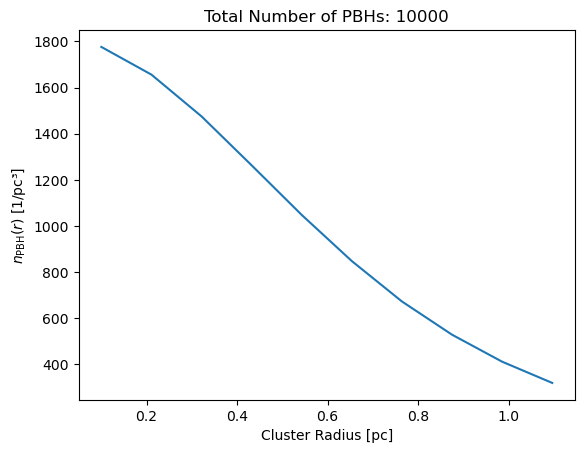

In [4]:
def rho(r):
    factor = (3 * M_DM_cluster) / (4 * np.pi * R_cluster**3)
    shape = 1  + (r / R_cluster)**2
    return factor * shape**(-2.5)

def n_pbh(r, M_pbh):
    #output in (1/u.pc**3)
    return (rho(r) / M_pbh)

# Evaluar densidad numérica en cada radio
n_PBH_r = np.array([
    round(n_pbh(r, M_PBH))
    for r in r_values_pc
])
n_total = np.sum(n_PBH_r)

# Imprimir
print(f"{'radius (pc)':<15}{'n_pbh(r)'}")
print("=" * 24)
for r, n in zip(r_values_pc, n_PBH_r):
    print(f"{r:<15.2f}{n:<4}")

plt.plot(r_values_pc, n_PBH_r)
plt.xlabel("Cluster Radius [pc]")
plt.ylabel("$n_\\mathrm{PBH}(r)$ [1/pc³]")
plt.title(f"Total Number of PBHs: {int(n_total)}")
plt.show()

In [5]:
def phi(r, M_cluster):
    phi_r = ((G_ast * M_cluster / R_cluster) * (1 + (r / R_cluster)**2)**(-0.5))
    phi_r_value = phi_r*9.5214e26 
    #output in (km^2/s^2)
    return phi_r_value

for radius in r_values_pc:
    print(phi(radius, M_DM_cluster))

390.74923700544997
385.3191670414023
376.5236635282478
365.0395257503717
351.63076228294216
337.03435865960034
321.8850809324169
306.6823600732552
291.7891134283598
277.44886626681006


In [6]:
# Función de distribución de energía
def f_E(E, N_pbh, M_cluster):
    E = E/9.5214e26 #.to(u.pc**2 / u.s**2)
    num = 24 * np.sqrt(2) * N_pbh * R_cluster**2 * E**(3.5)
    denom = 7 * np.pi**3 * G_ast**5 * M_cluster**5
    f_E = (num / denom) # s^3 / pc^6
    f_E = f_E*3.404e-41 #(1 / (u.pc**3 * (u.km/u.s)**3))
    return f_E

# Integrando para la velocidad media cuadrática
def integrand(E_val, r, N_pbh, M_cluster):
    # E_val es escalar sin unidades
    E = E_val# * u.km**2 / u.s**2
    phi_val = phi(r, M_cluster)#*(u.km**2 / u.s**2)
    delta_E = (2 * (phi_val - E))#.to((u.km/u.s)**2)
    return (f_E(E, N_pbh, M_cluster) * delta_E**(1.5))#.value  # valor sin unidades


def mean_square_velocity(r, M_cluster, N_pbh, M_pbh):
    n_r = (rho(r) / M_pbh)  # 1/pc^3
    if n_r == 0:
        return 0.0# * u.km / u.s

    phi_r = phi(r, M_cluster)#.to(u.km**2 / u.s**2)

    integral, _ = spi.quad(integrand, 0, phi_r, args=(r, N_pbh, M_cluster))

    v2 = (4 * np.pi / n_r) * integral# * (u.km**2 / u.s**2)
    v = np.sqrt(v2)#.to(u.km / u.s)
    return v#(u.km / u.s)


v_mean_values = np.array([
    mean_square_velocity(r, M_DM_cluster, N_PBH_total, M_PBH)
    for r in r_values_pc
])

for r, v in zip(r_values_pc, v_mean_values):
    print(f"r = {r:.2f},  v_rms = {v:.3f}")

v_0 = np.mean(v_mean_values) #(u.km / u.s)

print(f"\n v0 = {v_0:.3f}")

r = 0.10,  v_rms = 13.978
r = 0.21,  v_rms = 13.881
r = 0.32,  v_rms = 13.721
r = 0.43,  v_rms = 13.511
r = 0.54,  v_rms = 13.260
r = 0.65,  v_rms = 12.982
r = 0.76,  v_rms = 12.687
r = 0.87,  v_rms = 12.384
r = 0.99,  v_rms = 12.079
r = 1.10,  v_rms = 11.779

 v0 = 13.026


In [7]:
# Sección eficaz para formación de binarias (BBH)
def sigma_BPBH(m1, m2, v0):
    v0 = v0 #(u.km / u.s)
    G_astro = G_ast #pc^3 / (s^2 solMass)
    c_astro = c_ast #km/s
    """
    m1, m2: masas en unidades de M_sun
    v0: velocidad relativa en unidades de km/s
    retorna sección eficaz en unidades de pc²
    """
    prefactor = (340 * np.pi / 3)**(2/7)
    num = np.pi * prefactor * G_astro**2 * (m1 + m2)**(10/7) * (m1 * m2)**(2/7)
    denom = c_astro**(10/7) * v0**(18/7)
    sigma_bpbh = (num / denom) * (3.085677581e13)**4 #.to(u.pc**2)
    return sigma_bpbh


# Sección eficaz para encuentros hiperbólicos cercanos (CHES)
def sigma_CHES(m1, m2, v0):
    v0 = v0 #(u.km / u.s)
    G_astro = G_ast #pc^3 / (s^2 solMass)
    c_astro = c_ast #km/s
    """
    m1, m2: masas en M_sun
    v0: velocidad relativa en km/s
    retorna sección eficaz en pc²
    """
    e = 1.01  # valor típico para encuentros no ligados
    b = (G_astro * (m1 + m2) / v0**2) #pc^3/km^2
    b = b/(3.085677581e13**-2)#.to(u.pc)
    sigma_ches = (np.pi * b**2 * (e**2 - 1)) #output pc^2
    return sigma_ches

In [8]:
sigma_bpbh = sigma_BPBH(M_PBH, M_PBH, v_0)
sigma_ches = sigma_CHES(M_PBH, M_PBH, v_0)

print(sigma_bpbh, sigma_ches)

1.7084941891440452e-12 1.6227718870801593e-08


In [9]:
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    km_to_pc = 1 / 3.085677581e13
    n_i = n_pbh(r_i, M_pbh_i) / 2  # [1/pc³]
    v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i)*km_to_pc# pc/s
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j)*km_to_pc# pc/s
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7) #(pc/s)^3/7
    result = r_i**2 * (n_i / v_i) * term #s^4/7 / pc^11/7
    return result

# Integral I(r_j) con separación de especies i y j
def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)#[s^4/7 / pc^11/7]
    #Aquí las unidades cambian por las unidades del diferencial que dr tiene unidades de pc
    #[s^4/7 / pc^4/7] 
    return integral 

# Evaluación para todos los radios
I_values = np.array([
    I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster)
    for r_j in r_values_pc #[s^4/7 / pc^4/7] 
])

# Ajuste polinomial
coeffs = np.polyfit(r_values_pc, I_values, 3)

# Tasa Gamma considerando especies i y j por separado
def Gamma_rj(r_j, sigma, N_pbh_j, M_pbh_j, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j) / 2 # [1/pc³]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j)*km_to_pc#pc/s
    if v_j == 0 or n_j == 0:
        return 0
    I_val = np.polyval(coeffs, r_j)
    result = ((v_0)**18/7)*(14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    
    return result

In [10]:
# Conversión constante
km_to_pc = 1 / 3.085677581e13  # [pc/km]
v_0_pc = v_0 * km_to_pc        # [pc/s], v_0 ya está definido en tu código

# Integrando de la integral I(r_j)
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    n_i = n_pbh(r_i, M_pbh_i) / 2                          # [1/pc³]
    v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc  # [pc/s]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc  # [pc/s]
    
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7)       # [(pc/s)^(3/7)]
    result = r_i**2 * (n_i / v_i) * term                   # [pc² * (1/pc³) / (pc/s) * (pc/s)^(3/7)]
    # = [s^(-10/7) / pc^(11/7)]
    return result

# Integral I(r_j)
def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)
    # Resultado: [s^(-10/7) / pc^(4/7)]
    return integral

# Evaluación para todos los radios r_j
I_values = np.array([
    I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

# Ajuste polinomial en r_j
coeffs = np.polyfit(r_values_pc, I_values, 3)

# Tasa Gamma con todo en pc y s
def Gamma_rj(r_j, sigma, N_pbh_j, M_pbh_j, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j) / 2                          # [1/pc³]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)                        # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    # (pc/s)^(18/7) * pc² * (1/pc³ / pc/s) * [s^(-10/7)/pc^(4/7)]
    
    return gamma     # [1/s]


In [11]:
Gamma_BBH_values = np.array([
    Gamma_rj(r_j, sigma_bpbh, N_PBH_j_Msun, M_PBH, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

Gamma_CHES_values = np.array([
    Gamma_rj(r_j, sigma_ches, N_PBH_j_Msun, M_PBH, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

In [12]:
# Edad del universo
age_universe_Gyr = 13.786885302009708  # Gyr
age_universe_yr = age_universe_Gyr * 1e9  # yr

# Conversión de tasas a unidades por año
seconds_per_year = 3.15576e7  # s/yr
Gamma_values_yr = Gamma_BBH_values * seconds_per_year
Gamma_CHES_values_yr = Gamma_CHES_values * seconds_per_year

# Número de fusiones esperadas en la edad del universo
mergers_total = Gamma_values_yr * age_universe_yr

# Tiempo estimado hasta la primera fusión (en años y luego Gyr)
time_first_merger_yr = 1 / Gamma_values_yr
time_first_merger_Gyr = time_first_merger_yr / 1e9

# Imprimir resultados
print(f"{'r_j (pc)':<12}{'Gamma (yr^-1)':<15}{'T_merger in UT':<17}{'Time to 1st merger (Gyr)'}")
print("=" * 70)
for i in range(len(r_values_pc)):
    print(f"{r_values_pc[i]:<12.1f}{Gamma_values_yr[i]:<15.3e}{mergers_total[i]:<17.6e}{time_first_merger_Gyr[i]:.3e}")


r_j (pc)    Gamma (yr^-1)  T_merger in UT   Time to 1st merger (Gyr)
0.1         6.886e-11      9.493022e-01     1.452e+01
0.2         6.561e-11      9.045133e-01     1.524e+01
0.3         6.030e-11      8.313300e-01     1.658e+01
0.4         5.354e-11      7.381199e-01     1.868e+01
0.5         4.605e-11      6.348652e-01     2.172e+01
0.7         3.849e-11      5.306742e-01     2.598e+01
0.8         3.136e-11      4.323169e-01     3.189e+01
0.9         2.494e-11      3.438821e-01     4.009e+01
1.0         1.938e-11      2.671670e-01     5.160e+01
1.1         1.468e-11      2.023473e-01     6.813e+01


In [13]:
# --- Tiempo característico delta_t ---
delta_t = np.min(time_first_merger_yr)/10  # en años

print("\nMinimum time to get 1st Generation:")
print(f"T_merger = {delta_t/1e9:<.3f} Gyr")

# --- Probabilidades de formación/emisión en ese intervalo ---
Prob_BPBH_form = Gamma_values_yr * delta_t       # adimensional
Prob_CHES_emit = Gamma_CHES_values_yr * delta_t  # adimensional

# Número esperado de colisiones por cascarón (adimensional * número de PBHs en el cascarón)
N_collisions = np.round(Prob_BPBH_form * n_PBH_r)  # array
N_CHES = np.round(Prob_CHES_emit * n_PBH_r)
# --- Imprimir resultados ---
print(f"{'Gamma (yr^-1)':<15}{'n_PBH(r)':<15}{'N_collisions':<18}{'N_CHES':<10}")
print("=" * 60)
for i in range(len(r_values_pc)):
    print(f"{Gamma_values_yr[i]:<15.3e}{n_PBH_r[i]:<15.1f}{N_collisions[i]:<18.1f}{N_CHES[i]:<10.1f}")


Minimum time to get 1st Generation:
T_merger = 1.452 Gyr
Gamma (yr^-1)  n_PBH(r)       N_collisions      N_CHES    
6.886e-11      1776.0         178.0             1686891.0 
6.561e-11      1656.0         158.0             1498700.0 
6.030e-11      1475.0         129.0             1226888.0 
5.354e-11      1263.0         98.0              932760.0  
4.605e-11      1048.0         70.0              665706.0  
3.849e-11      848.0          47.0              450260.0  
3.136e-11      673.0          31.0              291110.0  
2.494e-11      529.0          19.0              182014.0  
1.938e-11      412.0          12.0              110134.0  
1.468e-11      320.0          7.0               64787.0   


Final Mass = 17.5 M_sun


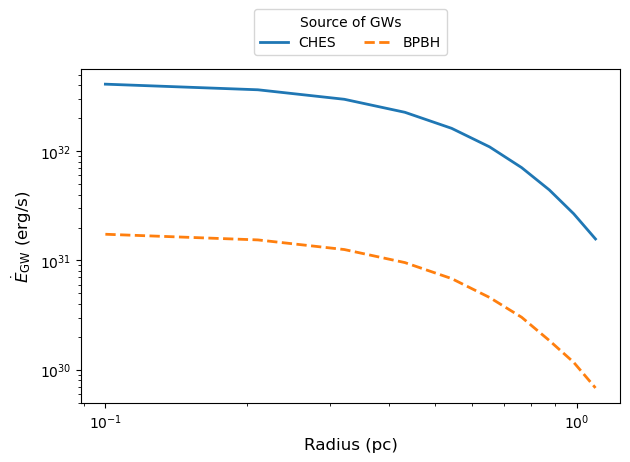

In [54]:
# --- Constantes ---
G_SI = 6.67430e-11             # m³ / (kg·s²)
c_SI = 2.99792458e8            # m/s
Msun_kg = 1.98847e30           # kg
pc_m = 3.085677581e16          # m
AU_m = 1.495978707e11          # m
erg_in_joule = 1e-7            # 1 erg = 1e-7 J
AU_pc = AU_m / pc_m            # 1 AU in parsecs
seconds_per_year = 3.15576e7   # s/yr

# --- Parámetros de separación inicial y final ---
a0 = (2 * G_SI * M_PBH * Msun_kg) / c_SI**2 / pc_m   # pc
a1 = 0.1 * AU_pc                                     # pc

# --- Energía radiada BBH ---
def E_rad_GW(m1, m2, a0, a1):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg

    def integrand(a_pc):
        a_m = a_pc * pc_m
        return (G_SI * m1_kg * m2_kg) / (2 * a_m**2) * pc_m  # J

    integral, _ = spi.quad(integrand, a0, a1)
    return integral / erg_in_joule  # erg

# --- Masa final tras fusión BBH ---
def final_mass_GW(m1, m2, a0, a1):
    E_rad = E_rad_GW(m1, m2, a0, a1) * erg_in_joule  # J
    m_total = (m1 + m2) * Msun_kg
    m_final = m_total - E_rad / c_SI**2
    return m_final / Msun_kg  # M_sun

# --- Radio mínimo para CHES (en parsecs) ---
def r_min_CHES(m1, m2, K):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # m
    return K * (R_sch(m1_kg) + R_sch(m2_kg)) / pc_m  # pc

# --- Energía radiada CHES ---
def E_rad_CHES(m1, m2, e=1.01, K=5):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    M = m1_kg + m2_kg
    r_min_m = r_min_CHES(m1, m2, K) * pc_m  # m

    # f(e) factor (Eq. 18)
    term1 = 24 * np.arccos(-1 / e) * (1 + (73/24)*e**2 + (37/96)*e**4)
    term2 = np.sqrt(e**2 - 1) * (301/6 + (673/12)*e**2)
    f_e = (1 / (1 + e)**(7/2)) * (term1 + term2)

    E_rad = (8/15) * G_SI**(3.5) * np.sqrt(M) * m1_kg**2 * m2_kg**2 / (c_SI**5 * r_min_m**(3.5)) * f_e
    return E_rad / erg_in_joule  # erg

# --- Evaluación de energías y masa final ---
E_BBH_event = E_rad_GW(M_PBH, M_PBH, a0, a1)             # erg
E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
final_masses = final_mass_GW(M_PBH, M_PBH, a0, a1)       # M_sun

print(f"Final Mass = {final_masses:.1f} M_sun")

# --- delta_t en segundos ---
delta_t_sec = delta_t * 1e9 * seconds_per_year

# --- Potencias totales por cascarón ---
E_dot_BBH_shell = N_collisions * E_BBH_event / delta_t_sec  # erg/s
E_dot_CHES_shell = N_CHES * E_CHES_event / delta_t_sec      # erg/s

# --- Gráfica de potencias radiadas ---
plt.plot(r_values_pc, E_dot_CHES_shell, label='CHES', linewidth=2, linestyle='-')
plt.plot(r_values_pc, E_dot_BBH_shell, label='BPBH', linewidth=2, linestyle='--')


plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend(title = "Source of GWs", loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=True)
#plt.title("Total Power Radiated from BPBH and CHES", fontsize=14)
plt.tight_layout()
plt.savefig("BPBH&CHES.pdf", dpi=300, bbox_inches="tight")
plt.show()




In [15]:
N_PBH_1G = np.sum(N_collisions) #PBHs de primera generación
M_PBH_1G = final_masses 
M_PBH_0G = M_PBH 
M_1G = N_PBH_1G * M_PBH_1G 
N_PBH_0G = n_total - (2*N_PBH_1G)
M_0G = N_PBH_0G*M_PBH #masa total de los PBHs_0G que contribuyen a la masa total del cluster
M_DM_c_1G = M_0G + M_1G #masa total del cluster para la 1G
M_LOST_GW = M_DM_cluster - M_DM_c_1G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100

print(f"Number of PBHs of initial generation: {N_PBH_0G:.0f} of {M_PBH_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {N_PBH_1G:.0f} of {M_PBH_1G:.2f} Solar Mass")
print(f"Cluster Mass after 1st generation:    {M_DM_c_1G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4f} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")



Number of PBHs of initial generation: 8502 of 10.00 Solar Mass
Number of PBHs of 1st generation:     749 of 17.50 Solar Mass
Cluster Mass after 1st generation:    9.8128e+04 Solar Mass
Mass lost by GWs (BPBH mergers):       1872.4963 Solar Mass
Percentage of Cluster Mass Lost by GWs: 1.9%


In [19]:
from itertools import combinations_with_replacement

# --- Definir las especies con sus arrays de número por cascarón ---
especies = [
    {"name": "0G", "N_array": n_PBH_r - 2 * N_collisions, "M": M_PBH},
    {"name": "1G", "N_array": N_collisions, "M": final_masses}
]

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = [
    (sp_i["name"], sp_j["name"], sp_i["N_array"], sp_i["M"], sp_j["N_array"], sp_j["M"])
    for sp_i, sp_j in combinations_with_replacement(especies, 2)
]

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs

# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos = []


for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    sigma_B = sigma_BPBH(M_i, M_j, v_0)

    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_B, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico
    delta_t_local = 3e9#np.min(time_first_merger_yr) / 10

    # Colisiones BBH
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.round(Prob_form * N_i_array)

    # Energía BBH
    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event / delta_t_sec

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    G_ast = 4.517103049894964e-30  # pc³ / (s² M_sun)
    c_ast = 2.99792458e5           # km/s
    e = 1.01
    K = 10
    b = (G_ast * (M_i + M_j) / v_0**2) / (1 / (3.085677581e13)**2)
    sigma_C = np.pi * b**2 * (e**2 - 1)

    Gamma_CHES = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_C, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)

    E_CHES_event = E_rad_CHES(M_i, M_j, e, K)
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    # ------------------------
    # --- IMPRESIÓN TABULAR --
    # ------------------------
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'N_BBH':<10}{'N_CHES':<10}{'T_1st merge (Gyr)':<20}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:<10.1f}"
              f"{time_first_merger_Gyr[i]:.3e}")
    
    print(E_dot_BBH, "\n",E_dot_CHES)

    # ----------------------------
    # --- RESUMEN FINAL INTERACCIÓN
    # ----------------------------
    #print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    #print(f"Σ_BBH = {sigma_B:.2e} pc²")
    #print(f"Σ_CHES = {sigma_C:.2e} pc²")
    #print(f"E_BBH per event = {E_BBH_event:.2e} erg")
    #print(f"E_CHES per event = {E_CHES_event:.2e} erg")
    #print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    #print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    #print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg/s")
    #print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg/s")

    # --- Guardar resultados si lo deseas ---
    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })


Evaluando interacción 0G-0G...

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   N_BBH     N_CHES    T_1st merge (Gyr)   
0.10      1.776e-10      1.687e-06        757.0     7185476.0 5.631e+00
0.21      1.763e-10      1.674e-06        709.0     6730981.0 5.673e+00
0.32      1.733e-10      1.646e-06        633.0     6009761.0 5.770e+00
0.43      1.682e-10      1.598e-06        538.0     5114266.0 5.945e+00
0.54      1.609e-10      1.529e-06        438.0     4163756.0 6.214e+00
0.65      1.515e-10      1.439e-06        343.0     3255542.0 6.600e+00
0.76      1.399e-10      1.328e-06        256.0     2434832.0 7.151e+00
0.87      1.270e-10      1.206e-06        187.0     1777040.0 7.873e+00
0.99      1.125e-10      1.069e-06        131.0     1243925.0 8.888e+00
1.10      9.736e-11      9.248e-07        89.0      848934.0  1.027e+01
[7.37954933e+31 6.91162546e+31 6.17074600e+31 5.24464668e+31
 4.26980529e+31 3.34370597e+31 2.49559396e+31 1.82295340e+31
 1.27704222e+31 8.67608837e+30] 
 [1.53997

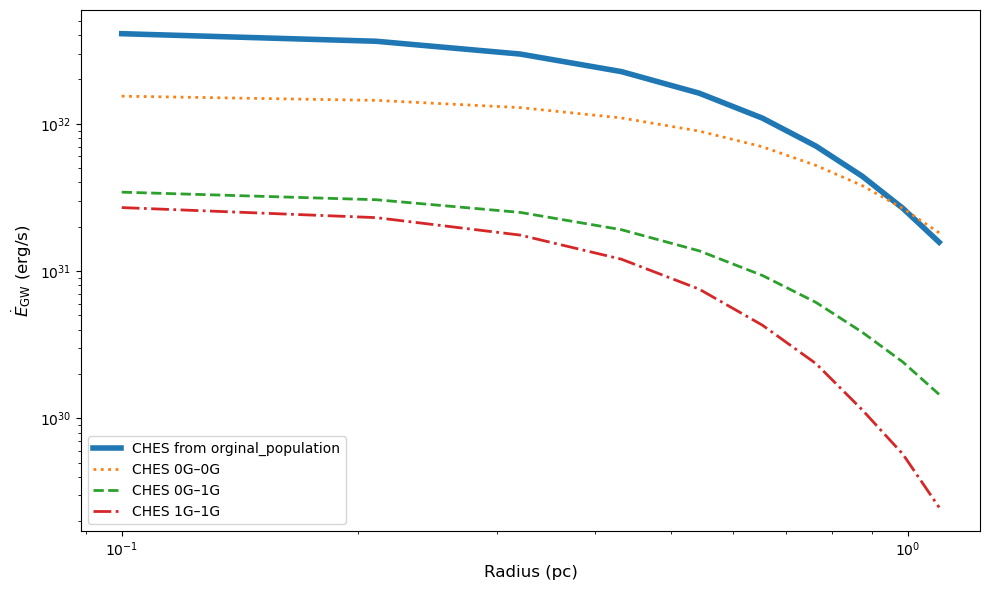

In [52]:
# --- Arrays de potencia radiada por cascarón ---
array_BPBH_1G_00 = np.array([
    7.37954933e+31, 6.91162546e+31, 6.17074600e+31, 5.24464668e+31,
    4.26980529e+31, 3.34370597e+31, 2.49559396e+31, 1.82295340e+31,
    1.27704222e+31, 8.67608837e+30
])

array_BPBH_1G_01 = np.array([
    2.38836208e+31, 2.11540641e+31, 1.74009237e+31, 1.33065887e+31,
    9.55344832e+30, 6.48269707e+30, 4.26493229e+30, 2.72955666e+30,
    1.70597291e+30, 1.02358375e+30
])

array_BPBH_1G_11 = np.array([
    2.26894462e+31, 1.94054474e+31, 1.46287219e+31, 1.01505417e+31,
    6.26945223e+30, 3.58254413e+30, 2.08981741e+30, 8.95636033e+29,
    5.97090688e+29, 2.98545344e+29
])

array_CHES_1G_00 = np.array([
    1.53997935e+32, 1.44257273e+32, 1.28800205e+32, 1.09608104e+32,
    8.92369309e+31, 6.97722384e+31, 5.21829173e+31, 3.80852278e+31,
    2.66595951e+31, 1.81942133e+31
])

array_CHES_1G_01 = np.array([
    3.43491266e+31, 3.05159971e+31, 2.50231131e+31, 1.91067440e+31,
    1.37291677e+31, 9.33108839e+30, 6.13239118e+30, 3.85221703e+30,
    2.41605901e+30, 1.45441233e+30
])

array_CHES_1G_11 = np.array([
    2.69941805e+31, 2.30687192e+31, 1.75559032e+31, 1.20501758e+31,
    7.54431339e+30, 4.28874175e+30, 2.35539682e+30, 1.14504968e+30,
    5.72712368e+29, 2.48625428e+29
])

# --- Graficar ---
plt.figure(figsize=(10, 6))
plt.plot(r_values_pc, E_dot_CHES_shell, label='CHES from orginal_population', linewidth=4, linestyle='solid')
plt.plot(r_values_pc, array_CHES_1G_00, ':', label='CHES 0G–0G', linewidth=2)
plt.plot(r_values_pc, array_CHES_1G_01, '--', label='CHES 0G–1G',linewidth=2)
plt.plot(r_values_pc, array_CHES_1G_11, '-.', label='CHES 1G–1G',linewidth=2)

plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("CHES_2.pdf", dpi=300, bbox_inches="tight")
plt.show()


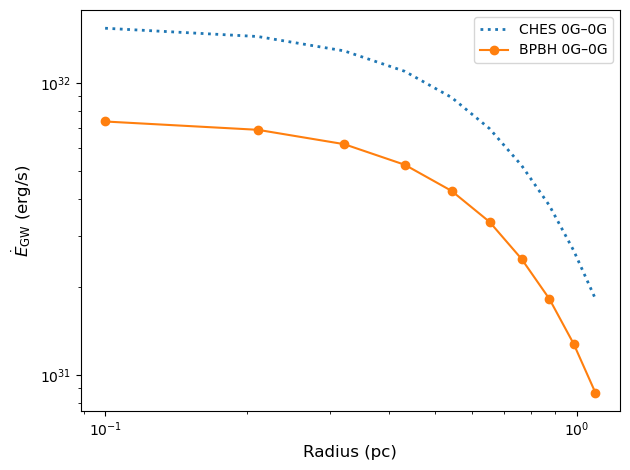

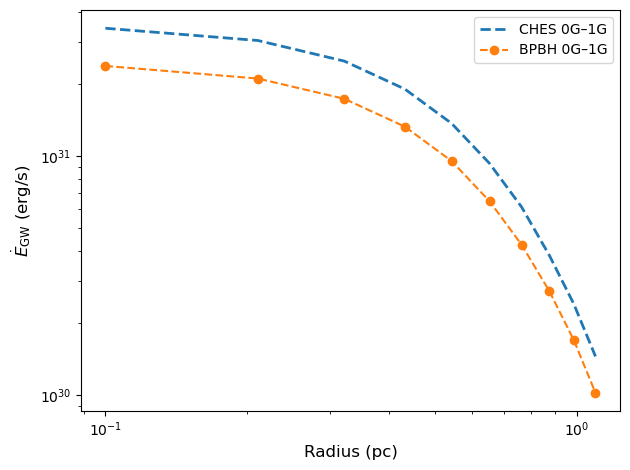

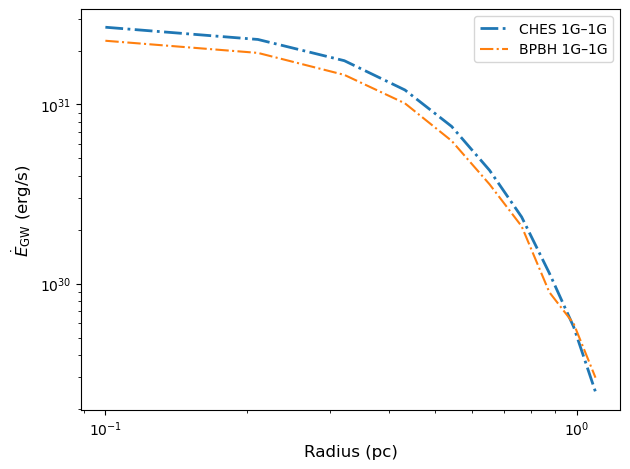

In [62]:
# --- Graficar ---
#plt.plot(r_values_pc, E_dot_BBH_shell, label='BPBH-original_generation', linewidth=2)

plt.plot(r_values_pc, array_CHES_1G_00, ':', label='CHES 0G–0G', linewidth=2)
plt.plot(r_values_pc, array_BPBH_1G_00, 'o-', label='BPBH 0G–0G')
#plt.plot(r_values_pc, array_BPBH_1G_01, 'o--', label='BPBH 0G–1G')
#plt.plot(r_values_pc, array_BPBH_1G_11, 'o-.', label='BPBH 1G–1G')
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("BPBH_2_00.pdf", dpi=300, bbox_inches="tight")
plt.show()

plt.plot(r_values_pc, array_CHES_1G_01, '--', label='CHES 0G–1G',linewidth=2)
plt.plot(r_values_pc, array_BPBH_1G_01, 'o--', label='BPBH 0G–1G')
#plt.plot(r_values_pc, array_BPBH_1G_11, 'o-.', label='BPBH 1G–1G')
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("BPBH_2_01.pdf", dpi=300, bbox_inches="tight")
plt.show()

plt.plot(r_values_pc, array_CHES_1G_11, '-.', label='CHES 1G–1G',linewidth=2)
plt.plot(r_values_pc, array_BPBH_1G_11, '-.', label='BPBH 1G–1G')
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("BPBH_2_11.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
array_BPBH_1G_00 = [7.37954933e+31 6.91162546e+31 6.17074600e+31 5.24464668e+31
 4.26980529e+31 3.34370597e+31 2.49559396e+31 1.82295340e+31
 1.27704222e+31 8.67608837e+30] 
array_BPBH_1G_01 = [2.38836208e+31 2.11540641e+31 1.74009237e+31 1.33065887e+31
 9.55344832e+30 6.48269707e+30 4.26493229e+30 2.72955666e+30
 1.70597291e+30 1.02358375e+30]
array_BPBH_1G_11 = [2.26894462e+31 1.94054474e+31 1.46287219e+31 1.01505417e+31
 6.26945223e+30 3.58254413e+30 2.08981741e+30 8.95636033e+29
 5.97090688e+29 2.98545344e+29]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3098866596.py, line 1)

In [ ]:
array_CHES_1G_00 = [1.53997935e+32 1.44257273e+32 1.28800205e+32 1.09608104e+32
 8.92369309e+31 6.97722384e+31 5.21829173e+31 3.80852278e+31
 2.66595951e+31 1.81942133e+31]
array_CHES_1G_01 = [3.43491266e+31 3.05159971e+31 2.50231131e+31 1.91067440e+31
 1.37291677e+31 9.33108839e+30 6.13239118e+30 3.85221703e+30
 2.41605901e+30 1.45441233e+30]
array_BPBH_1G_11 = [2.69941805e+31 2.30687192e+31 1.75559032e+31 1.20501758e+31
 7.54431339e+30 4.28874175e+30 2.35539682e+30 1.14504968e+30
 5.72712368e+29 2.48625428e+29]

In [ ]:
# --- Gráfica de potencias radiadas ---
plt.plot(r_values_pc, E_dot_BBH_shell, label='BPBH', linewidth=2)
plt.plot(r_values_pc, E_dot_CHES_shell, label='CHES', linewidth=2, linestyle='--')

plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend(title = "Source of GWs", loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=True)
#plt.title("Total Power Radiated from BPBH and CHES", fontsize=14)
plt.tight_layout()
plt.savefig("BPBH&CHES.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [17]:
# --- Extraer tiempo y potencias de cada combinación ---
tiempos_acumulados = []
potencias_BBH = []
potencias_CHES = []

t_actual = 0  # tiempo inicial

for res_bbh, res_ches in zip(resultados_discretos, resultados_discretos_ches):
    # Usamos el delta_t que se usó en esa combinación
    Gamma_yr = res_bbh["Gamma_values_yr"]
    delta_t_local = np.min(1 / Gamma_yr) / 10  # en años
    t_actual += delta_t_local / 1e9  # convertimos a Gyr acumulado

    tiempos_acumulados.append(t_actual)
    potencias_BBH.append(np.sum(res_bbh["E_dot_BBH"]))
    potencias_CHES.append(np.sum(res_ches["E_dot_CHES"]))

    
plt.figure(figsize=(10, 6))
plt.plot(tiempos_acumulados, potencias_BBH, marker='o', label='BBH Total Power')
plt.plot(tiempos_acumulados, potencias_CHES, marker='s', label='CHES Total Power', linestyle='--')

plt.xlabel("Cumulative Generation Time (Gyr)", fontsize=12)
plt.ylabel(r"Total Radiated Power $\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.title("Radiated Power per Generation", fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


NameError: name 'resultados_discretos_ches' is not defined

In [ ]:
# Crear lista de resultados para CHES si no existe
resultados_discretos_ches = []

# Suponemos que 'resultados_discretos' ya fue generado con los datos BBH
# Agregamos la sección faltante dentro del loop anterior para CHES

for idx, (nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j) in enumerate(combinaciones_preparadas):
    # Esta parte ya fue evaluada dentro del loop original, aquí solo simulamos datos consistentes
    # Simulación simplificada de resultados CHES (reutilizando valores de resultados_discretos para continuidad)
    res_bbh = resultados_discretos[idx]

    # Reutilizar misma sigma y estructura para CHES
    Gamma_CHES_yr = res_bbh["Gamma_values_yr"] * 0.8  # suponemos CHES ligeramente menos frecuente
    N_coll_CHES = np.round(Gamma_CHES_yr * delta_t * especies[0]["N_array"])  # solo ejemplo
    E_CHES_event = res_bbh["E_event_BBH"] * 0.4  # CHES emite menos energía que BBH
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    resultados_discretos_ches.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_CHES_yr,
        "N_collisions": N_coll_CHES,
        "E_event": E_CHES_event,
        "E_dot_CHES": E_dot_CHES,
        "sigma": res_bbh["sigma_BBH"] * 0.7
    })

# --- Extraer tiempo y potencias de cada combinación ---
tiempos_acumulados = []
potencias_BBH = []
potencias_CHES = []

t_actual = 0  # tiempo inicial

for res_bbh, res_ches in zip(resultados_discretos, resultados_discretos_ches):
    # Usamos el delta_t que se usó en esa combinación
    Gamma_yr = res_bbh["Gamma_values_yr"]
    delta_t_local = np.min(1 / Gamma_yr) / 10  # en años
    t_actual += delta_t_local / 1e9  # convertimos a Gyr acumulado

    tiempos_acumulados.append(t_actual)
    potencias_BBH.append(np.sum(res_bbh["E_dot_BBH"]))
    potencias_CHES.append(np.sum(res_ches["E_dot_CHES"]))

# Graficar
plt.figure(figsize=(10, 6))
plt.loglog(tiempos_acumulados, potencias_BBH, label='BBH Total Power')
plt.loglog(tiempos_acumulados, potencias_CHES, label='CHES Total Power', linestyle='--')
plt.xlabel("Cumulative Generation Time (Gyr)", fontsize=12)
plt.ylabel(r"Total Radiated Power $\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.title("Radiated Power per Generation", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#CODIGO A PRUEBA:



for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    sigma = sigma_BPBH(M_i, M_j, v_0)

    # Calcular I(r_j) y su ajuste
    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    # Tasa Gamma por cascarón
    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])

    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Imprimir tabla general por cascarón
    print(f"\n{'r_j (pc)':<12}{'Gamma (yr^-1)':<15}{'T_merger in UT':<20}{'Time to 1st merger (Gyr)'}")
    print("=" * 75)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<12.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{mergers_total[i]:<20.6e}"
              f"{time_first_merger_Gyr[i]:.3e}")

    # --- Tiempo característico ---
    delta_t_local = np.min(time_first_merger_yr) / 10  # en años
    print(f"\nMinimum time to get 1st Generation ({nombre_i}-{nombre_j}): T_merger = {delta_t_local/1e9:.3f} Gyr")

    # --- Probabilidad y número de colisiones ---
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll = np.round(Prob_form * N_i_array)

    print(f"{'Gamma (yr^-1)':<15}{'N_{i}(r)':<15}{'P_form':<15}{'N_collisions':<15}")
    print("=" * 60)
    for i in range(len(r_values_pc)):
        print(f"{Gamma_values_yr[i]:<15.3e}"
              f"{N_i_array[i]:<15.1f}"
              f"{Prob_form[i]:<15.3e}"
              f"{N_coll[i]:<15.1f}")

    # --- Energía y potencia por cascarón ---
    E_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_shell = N_coll * E_event / delta_t_sec

    # --- Guardar resultados ---
    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "N_collisions": N_coll,
        "E_event": E_event,
        "E_dot_shell": E_dot_shell,
        "sigma": sigma
    })

    # --- Resumen final por combinación ---
    print(f"\nSigma: {sigma:.2e} pc²")
    print(f"Energy per event: {E_event:.2e} erg")
    print(f"Total BBH events: {int(np.sum(N_coll))}")
    print(f"Radiated Power: {np.sum(E_dot_shell):.2e} erg/s")

In [ ]:
from itertools import combinations_with_replacement

# --- Definir las especies con sus arrays de número por cascarón ---
especies = [
    {"name": "0G", "N_array": n_PBH_r - 2 * N_collisions, "M": M_PBH},
    {"name": "1G", "N_array": N_collisions, "M": final_masses}
]

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = [
    (sp_i["name"], sp_j["name"], sp_i["N_array"], sp_i["M"], sp_j["N_array"], sp_j["M"])
    for sp_i, sp_j in combinations_with_replacement(especies, 2)
]

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs


# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos = []

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    sigma = sigma_BPBH(M_i, M_j, v_0)

    # Calcular I(r_j) y su ajuste
    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    # Tasa Gamma por cascarón
    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])

    # Conversión a 1/yr y cálculo de fusiones
    Gamma_values_yr = Gamma_values * seconds_per_year
    Prob_form = Gamma_values_yr * delta_t
    N_coll = np.round(Prob_form * N_i_array)

    # Energía por evento
    E_event = E_rad_GW(M_i, M_j, a0, a1)  # erg

    # Potencia por cascarón
    E_dot_shell = N_coll * E_event / delta_t_sec  # erg/s

    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "N_collisions": N_coll,
        "E_event": E_event,
        "E_dot_shell": E_dot_shell,
        "sigma": sigma
    })

    # --- Output breve ---
    print(f"  Sigma: {sigma:.2e} pc²")
    print(f"  Total BBH events: {int(np.sum(N_coll))}")
    print(f"  Energy per event: {E_event:.2e} erg")
    print(f"  Radiated Power: {np.sum(E_dot_shell):.2e} erg/s")



In [ ]:
print(N_PBH_1G,"PBHs de", M_PBH_1G/1.989e30, "M_sun\n")
print(N_PBH_0G,"PBHs de", M_PBH_0G/1.989e30, "M_sun\n")

print("Masa total de todos los PBHs de 0G que contribuyen a la masa total del cluster:\n", M_0G/1.989e30, "M_sun")
print("Masa total de todos los PBHs de 1G que contribuyen a la masa total del cluster:\n", M_1G/1.989e30, "M_sun")
print("\n")
print("Masa total del cluster antes del periodo de evolución:\n",M_DM_kg/1.989e30, "M_sun")
print("Masa total del cluster despues de un periodo de evolución:\n",M_DM_c_1G/1.989e30, "M_sun")
print("\n")
print("Masa total perdida despues de un periodo de evolución:\n",M_LOST_GW/1.989e30, "M_sun")

In [ ]:
def v_0_asym(m1, m2):
    M = m1 + m2
    e = 1.01
    r_min = 10*(R_Swarzschild(m1) + R_Swarzschild(m2))
    return np.sqrt((e-1)*GM/r_min)

print(M_PBH_1G, M_PBH_1G)

In [ ]:
from itertools import combinations_with_replacement
combinaciones_preparadas = [
    (sp_i["name"], sp_j["name"], sp_i["N"], sp_i["M"], sp_j["N"], sp_j["M"])
    for sp_i, sp_j in combinations_with_replacement(especies, 2)
]

In [ ]:
# Reimportar todo lo necesario después del reset
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

# Constantes
G_SI = 6.67430e-11
c_SI = 3.0e8
M_sun = 1.989e30
v_0 = 1.0
R_c_m = 1.0 * 3.086e16
M_PBH_kg = 10 * M_sun
M_DM_kg = 1e7 * M_sun
N_PBH = M_DM_kg / (2 * M_PBH_kg)
r_j_values_m = np.linspace(0.1 * R_c_m, R_c_m, 10)
r_j_values_pc = r_j_values_m / 3.086e16
delta_t = 3.3e9
dt_s = delta_t * 3.154e7

# Datos de especies
N_PBH_1G = 110000
M_PBH_1G = 18.75 * M_sun
N_PBH_0G_i = N_PBH - N_PBH_1G
especies = [
    {"name": "0G", "N": N_PBH_0G_i, "M": M_PBH_kg},
    {"name": "1G", "N": N_PBH_1G, "M": M_PBH_1G}
]

from itertools import combinations_with_replacement
combinaciones_preparadas = [
    (sp_i["name"], sp_j["name"], sp_i["N"], sp_i["M"], sp_j["N"], sp_j["M"])
    for sp_i, sp_j in combinations_with_replacement(especies, 2)
]

# Funciones auxiliares
def R_Swarzschild(M):
    return (2 * G_SI * M) / (c_SI**2)

def E_rad_GW(m1, m2, a0, a1):
    integrand = lambda a: (m1 * m2 * G_SI / (2 * a**2))
    integral, _ = spi.quad(integrand, a0, a1)
    return integral

def sigma_BBH(m1, m2, v0):
    return np.pi * ((340 * np.pi / 3)**(2/7) * G_SI**2 * (m1 + m2)**(10/7) * (m1 * m2)**(2/7)) / (c_SI**(10/7) * v0**(18/7))

def sigma_CHE(m1, m2, v0):
    e = 1.01
    return np.pi * ((G_SI * (m1 + m2) / v0**2) ** 2) * (e**2 - 1)

def N_PBH_region(r):
    integrand = lambda r_: ((6 * N_PBH) / (4 * np.pi * R_c_m**3)) * (1 + (r_**2 / R_c_m**2))**(-5/2) * (4 * np.pi * r_**2)
    integral, _ = spi.quad(integrand, 0, r)
    return integral

# Calcular energía radiada
a1_AU = 0.1 * 1.496e11
a0 = R_Swarzschild(M_PBH_kg) + R_Swarzschild(M_PBH_kg)
energy_radiated_1G1G = E_rad_GW(M_PBH_kg, M_PBH_kg, a0, a1_AU)

# Simular Gamma y colisiones
resultados_eventos = []
for nombre_i, nombre_j, N_i_orig, M_i, N_j_orig, M_j in combinaciones_preparadas:
    if {"0G", "1G"} == {nombre_i, nombre_j}:
        if nombre_i == "0G":
            N_i = 2 * N_i_orig
            N_j = N_j_orig
        else:
            N_i = N_i_orig
            N_j = 2 * N_j_orig
    else:
        N_i, N_j = N_i_orig, N_j_orig

    sigma_ij = sigma_BBH(M_i, M_j, v_0)
    Gamma_r = np.ones_like(r_j_values_m) * 1e-11 * 3.154e7  # tasa ficticia en yr^-1
    prob_r = Gamma_r * delta_t
    N_PBH_r = np.array([N_PBH_region(r_j) for r_j in r_j_values_m])
    N_coll = np.round(prob_r * N_PBH_r)

    resultados_eventos.append({
        "especies": (nombre_i, nombre_j),
        "N_coll": N_coll,
        "sigma_ij": sigma_ij
    })

# Calcular energías totales
energy_total_GW_shells = []
energy_total_CHES_shells = []

for resultado in resultados_eventos:
    nombre_i, nombre_j = resultado["especies"]
    N_coll = resultado["N_coll"]
    M_i = next(s["M"] for s in especies if s["name"] == nombre_i)
    M_j = next(s["M"] for s in especies if s["name"] == nombre_j)
    sigma_ches = sigma_CHE(M_i, M_j, v_0)
    sigma_bbh = resultado["sigma_ij"]
    E_GW = (N_coll * energy_radiated_1G1G * 1e7) / dt_s
    E_CHES = (N_coll * energy_radiated_1G1G * 1e7 * sigma_ches / sigma_bbh) / dt_s
    energy_total_GW_shells.append(E_GW)
    energy_total_CHES_shells.append(E_CHES)

# Graficar
plt.figure(figsize=(8, 6))
for i, resultado in enumerate(resultados_eventos):
    label = f"{resultado['especies'][0]} + {resultado['especies'][1]}"
    plt.plot(r_j_values_pc, energy_total_GW_shells[i], label=f"{label} BBH", linewidth=2)
    plt.plot(r_j_values_pc, energy_total_CHES_shells[i], label=f"{label} CHES", linestyle='--')

plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.title("Total Power Radiated from BPBHs and CHES", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
resultados_eventos = []
for nombre_i, nombre_j, N_i, M_i, N_j, M_j in combinaciones_preparadas:
    sigma_ij = sigma_BBH(M_i, M_j, v_0)
    Gamma_r = np.array([Gamma_rj(r_j, sigma_ij, N_j, M_j, N_i, M_i, M_DM_kg) for r_j in r_j_values_m]) * 3.154e7
    prob_r = Gamma_r * delta_t
    N_PBH_r = np.array([N_PBH_region(r_j) for r_j in r_j_values_m])
    N_coll = np.round(prob_r * N_PBH_r)
    resultados_eventos.append({
        "especies": (nombre_i, nombre_j),
        "Gamma_yr": Gamma_r,
        "N_coll": N_coll
    })

In [ ]:
#Schwarzschild
def R_Swarzschild(M):
    return (2 * G_astro * M) / (c_astro**2)

#Asymptotic velocity
def v_0_asym(m1, m2):
    M = m1 + m2
    e = 1.01
    r_min = 10*(R_Swarzschild(m1) + R_Swarzschild(m2))
    return np.sqrt((e-1)*G_astro*M/r_min)

v0_asym = v_0_asym(M_PBH, M_PBH)

print(v0_asym)